Groundwater | Case Study

# Topic 4b : From Concept to Code: Adding Transport Processes to a Groundwater Flow Model

Dr. Xiang-Zhao Kong & Dr. Beatrice Marti & Louise Noël du Payrat

---
## 1. Introduction to Contaminant Transport Modeling

Contaminant transport in groundwater is governed by physical, chemical, and biological processes. Understanding these processes is essential for predicting plume migration, assessing risks, and designing remediation strategies.

### 1.1 Fundamental Transport Processes

**Advection** is the movement of dissolved contaminants with flowing groundwater:

$$v = \frac{K \cdot i}{n}$$

where $v$ is pore water velocity (m/day), $K$ is hydraulic conductivity (m/day), $i$ is hydraulic gradient (m/m), and $n$ is effective porosity (dimensionless).

**Dispersion** causes spreading of the contaminant plume beyond what advection alone would predict. It results from:
- **Mechanical dispersion**: Variations in velocity at pore scale and between flow paths
- **Molecular diffusion**: Random motion of molecules (typically negligible compared to mechanical dispersion)

**Sorption** is the attachment of contaminants to aquifer solids, causing **retardation**:

$$R = 1 + \frac{\rho_b \cdot K_d}{n}$$

where $R$ is the retardation factor (dimensionless), $\rho_b$ is bulk density (kg/m³), and $K_d$ is the distribution coefficient (mL/g).

**Decay** represents biodegradation or chemical transformation:

$$C(t) = C_0 \cdot e^{-\lambda t}$$

where $\lambda$ is the first-order decay constant (1/day), related to half-life by $t_{1/2} = \ln(2)/\lambda$.

### 1.2 Governing Equation

The 3D advection-dispersion-reaction equation describes contaminant transport:

$$
\frac{\partial C}{\partial t} = \nabla \cdot (D \nabla C) - \mathbf{v} \cdot \nabla C - \lambda C
$$

where:
- $C$ = concentration (mg/L)
- $t$ = time (days)
- $D$ = dispersion tensor (m²/day)
- $\mathbf{v}$ = velocity vector (m/day)
- $\lambda$ = decay constant (1/day)

For reactive transport, multiply $\frac{\partial C}{\partial t}$ by retardation factor $R$.

### 1.3 Analytical vs. Numerical Solutions

**Analytical solutions** exist for simplified conditions (1D, uniform flow, simple boundaries). **Example**: Ogata-Banks solution for 1D continuous source:

$$C(x,t) = \frac{C_0}{2}\left[\text{erfc}\left(\frac{x-vt}{2\sqrt{Dt}}\right) + e^{vx/D}\text{erfc}\left(\frac{x+vt}{2\sqrt{Dt}}\right)\right]$$

**Numerical solutions** (MT3D-USGS, MODFLOW 6 GWT) handle complex 2D/3D geometries, heterogeneity, wells, and boundaries.

### 1.4 MT3D-USGS: Modular Transport Simulator

MT3D-USGS (Bedekar et al., 2016) is the USGS version of MT3DMS, coupled with MODFLOW. It uses a **modular package structure**:

| Package | Purpose | Key Parameters |
|---------|---------|----------------|
| **BTN** | Basic Transport | Porosity, initial concentration, time steps |
| **ADV** | Advection | Numerical scheme (MOC, TVD, etc.) |
| **DSP** | Dispersion | Dispersivity ($\alpha_L$, $\alpha_T$, $\alpha_V$) |
| **SSM** | Source-Sink Mixing | Source locations and concentrations |
| **RCT** | Reactions | Sorption ($K_d$), decay ($\lambda$) |
| **GCG** | Solver | Convergence criteria |

MT3D reads flow velocities from MODFLOW output and solves transport on the same (or refined) grid.

### 1.5 When to Use Which Method?

```
Simple problem? → Try analytical first
├─ Uniform flow, 1D, no wells → Ogata-Banks
├─ Conservative tracer only → Particle tracking (MODPATH)
└─ Need verification → Always compare numerical to analytical

Complex problem? → Use numerical model
├─ Wells, boundaries, heterogeneity → MT3D-USGS
├─ Multiple contaminants → MT3D-USGS (multi-species)
└─ Regulatory/design decisions → MT3D-USGS (defensible)
```

**Professional practice**: Start simple, add complexity only when justified. Always verify numerical models against analytical solutions.

### 1.6 References

- Sale, T., & Scalia, J. (2025). Modern Subsurface Contaminant Hydrology, first edition. The Groundwater Project. [https://doi.org/10.62592/IQDO4854](https://doi.org/10.62592/IQDO4854).
- Bedekar, Vivek, Morway, E.D., Langevin, C.D., and Tonkin, Matt, 2016, MT3D-USGS version 1: A U.S. Geological Survey release of MT3DMS updated with new and expanded transport capabilities for use with MODFLOW: U.S. Geological Survey Techniques and Methods 6-A53, 69 p., [https://dx.doi.org/10.3133/tm6A53](https://dx.doi.org/10.3133/tm6A53).
- Ogata, A., & Banks, R.B. (1961). *Longitudinal Dispersion in Porous Media*. USGS Professional Paper 411-A. [https://pubs.usgs.gov/pp/0411a/report.pdf](https://pubs.usgs.gov/pp/0411a/report.pdf).
- Gelhar, L.W., et al. (1992). Field-scale dispersion in aquifers. *Water Resources Research*, 28(7), 1955-1974. [https://doi.org/10.1029/92WR00607](https://doi.org/10.1029/92WR00607).

---

Let's now see these concepts in practice with code examples in Section 2.

---
## 2. Transport Model Setup Fundamentals

This section demonstrates how to load a MODFLOW model and prepare it for transport modeling with MT3D-USGS.

### 2.1 Import Libraries

Import all necessary Python libraries for groundwater modeling, transport simulation, and visualization.

In [3]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# FloPy for MODFLOW and MT3D
import flopy

# print current working directory
print("Current working directory: ", os.getcwd())

# Add the support repo to the path
sys.path.append(os.path.abspath('../SUPPORT_REPO/src'))
sys.path.append(os.path.abspath('../SUPPORT_REPO/src/scripts/scripts_exercises'))


# Helper functions from course utilities
from data_utils import download_named_file, get_default_data_folder

print(f"FloPy version: {flopy.__version__}")
print("Libraries imported successfully.")

Current working directory:  /Users/bea/Documents/GitHub/applied_groundwater_modelling/CASE_STUDY
Starting search for project root from: /Users/bea/Documents/GitHub/applied_groundwater_modelling/CASE_STUDY
Checking path: /Users/bea/Documents/GitHub/applied_groundwater_modelling/CASE_STUDY
Marker file not found in /Users/bea/Documents/GitHub/applied_groundwater_modelling/CASE_STUDY. Moving up...
Checking path: /Users/bea/Documents/GitHub/applied_groundwater_modelling
Found project root: /Users/bea/Documents/GitHub/applied_groundwater_modelling (marker: config.py)
Loaded configuration from 'config.py'
FloPy version: 3.9.2
Libraries imported successfully.


### 2.2 Load and Run Parent Flow Model

Load the Limmat Valley base model and run steady-state flow simulation. Transport modeling requires a converged flow field to calculate groundwater velocities.

In [8]:
# Download parent base model
parent_base_flow_model_name = 'baseline_model_flow'

parent_base_flow_model_path = download_named_file(
    'baseline_model', 
    data_type='transport/flow_model',
)

# Handle zip file extraction if needed
if parent_base_flow_model_path.endswith('.zip'):
    import zipfile
    extract_path = os.path.dirname(parent_base_flow_model_path)
    with zipfile.ZipFile(parent_base_flow_model_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    # Find the .nam file
    parent_base_flow_model_path = os.path.join(extract_path, 'limmat_valley_model_nwt.nam')

print(f'Downloaded parent base model to: {parent_base_flow_model_path}')

limmat_valley_base_model_nwt.zip:   0%|          | 0.00/347k [00:00<?, ?iB/s]

Download complete: /Users/bea/applied_groundwater_modelling_data/limmat/transport/flow_model/limmat_valley_base_model_nwt.zip


limmat_valley_base_model_nwt_readme.md:   0%|          | 0.00/228 [00:00<?, ?iB/s]

Download complete: /Users/bea/applied_groundwater_modelling_data/limmat/transport/flow_model/limmat_valley_base_model_nwt_readme.md
Downloaded parent base model to: /Users/bea/applied_groundwater_modelling_data/limmat/transport/flow_model/limmat_valley_model_nwt.nam


In [9]:
# Define workspace for transport modeling
transport_ws = Path.home() / "applied_groundwater_modelling_data" / "limmat" / "transport"
flow_model_ws = transport_ws / "flow_model"
flow_model_ws.mkdir(parents=True, exist_ok=True)

print(f"Transport workspace: {transport_ws}")
print(f"Flow model workspace: {flow_model_ws}")

Transport workspace: /Users/bea/applied_groundwater_modelling_data/limmat/transport
Flow model workspace: /Users/bea/applied_groundwater_modelling_data/limmat/transport/flow_model


In [10]:
# Load MODFLOW model with FloPy
mf = flopy.modflow.Modflow.load(
    'limmat_valley_model_nwt.nam',
    model_ws=os.path.dirname(parent_base_flow_model_path),
    exe_name='mfnwt',  # MODFLOW-NWT executable
    version='mfnwt',
    check=False
)

print(f"Loaded MODFLOW model: {mf.name}")
print(f"Grid dimensions (nlay, nrow, ncol): {mf.nlay}, {mf.nrow}, {mf.ncol}")
print(f"Steady-state: {mf.dis.steady.array[0]}")

Loaded MODFLOW model: limmat_valley_model_nwt
Grid dimensions (nlay, nrow, ncol): 1, 48, 142
Steady-state: True


In [11]:
# Change model workspace to our transport directory and save
mf.change_model_ws(str(flow_model_ws))
mf.write_input()

print(f"Saved flow model to: {flow_model_ws}")

Saved flow model to: /Users/bea/applied_groundwater_modelling_data/limmat/transport/flow_model


In [12]:
# Run the flow model
success, buff = mf.run_model(silent=False)

if success:
    print("\n✓ Flow model converged successfully")
else:
    print("\n✗ Flow model failed to converge")
    print("Check output above for errors")

FloPy is using the following executable to run the model: ../../../../.local/share/flopy/bin/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.3.0 07/01/2022                        
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.05.0 03/10/2022                       

 Using NAME file: limmat_valley_model_nwt.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2025/11/02 15:00:40

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/11/02 15:00:41
 Elapsed run time:  0.051 Seconds

  Normal termination of simulation

✓ Flow model converged successfully


### 2.3 Load and Inspect Flow Results

Load the head file and cell-by-cell flow file to verify the flow solution and extract velocities for transport.

In [13]:
# Load head file
hds_file = flow_model_ws / f"{mf.name}.hds"
hds = flopy.utils.HeadFile(str(hds_file))

# Get heads for the single steady-state time step
heads = hds.get_data()

print(f"Head array shape: {heads.shape}")
print(f"Head range: {heads.min():.2f} to {heads.max():.2f} m")

Head array shape: (1, 48, 142)
Head range: -999.99 to 412.68 m


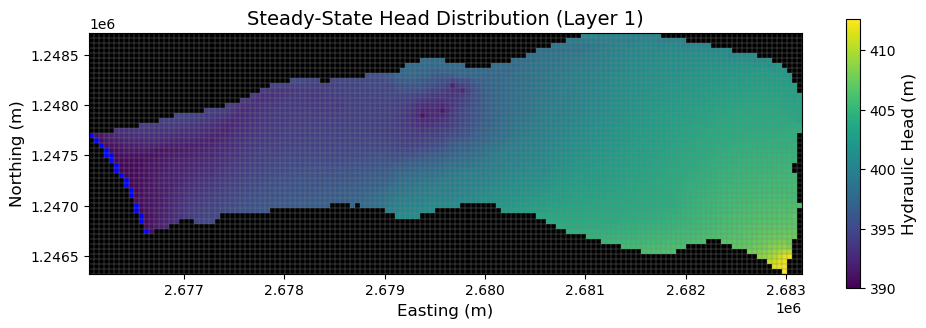

In [17]:
# Visualize head distribution
fig, ax = plt.subplots(figsize=(10, 8))

# Plot heads for layer 0
mapview = flopy.plot.PlotMapView(model=mf, layer=0, ax=ax)
quadmesh = mapview.plot_array(heads, cmap='viridis')
mapview.plot_grid(alpha=0.2)
mapview.plot_ibound()

# Add colorbar
cb = plt.colorbar(quadmesh, ax=ax, shrink=0.35)
cb.set_label('Hydraulic Head (m)', fontsize=12)

ax.set_title('Steady-State Head Distribution (Layer 1)', fontsize=14)
ax.set_xlabel('Easting (m)', fontsize=12)
ax.set_ylabel('Northing (m)', fontsize=12)

ax.set_aspect('equal')

plt.tight_layout()
plt.show()

### 2.4 Summary: Flow Model Ready for Transport

We now have:
- ✓ Parent flow model loaded and saved to transport workspace
- ✓ Steady-state flow simulation converged
- ✓ Head distribution verified and visualized
- ✓ Model ready for MT3D-USGS coupling

**Next steps**: In Section 3, we'll define contaminant sources. In Section 4, we'll create the MT3D-USGS model and couple it with this flow field.

---
## 3. Source Term Definition

### Learning Objectives
- Understand different source term types
- Learn to use the SSM (Source-Sink Mixing) package
- Map coordinates to model grid cells

### Section Content
- **Source types**:
  - Point sources (spills, injection wells)
  - Area sources (landfills, contaminated zones)
  - Line sources (leaking pipelines, rivers)
- **Release timing**:
  - Continuous sources (ongoing contamination)
  - Pulse sources (one-time release)
  - Variable sources (seasonal or episodic)
- **SSM package implementation**:
  - itype codes (-1 for constant concentration, 2 for wells, 15 for mass loading)
  - Stress period data structure
  - Concentration vs. mass loading approaches
- **Coordinate mapping**: Converting real-world coordinates to grid indices

### Implementation Approaches
**Approach 1: Constant Concentration Cell (itype = -1)**
- Best for: Continuous source zones, spills with sustained concentration
- Example: Landfill leachate pool, contaminated infiltration area

**Approach 2: Mass Loading (itype = 15)**
- Best for: Point sources with known mass flux
- Example: Direct injection of contaminant mass

**Approach 3: Well Concentration (itype = 2)**
- Best for: Contaminated injection wells
- Example: Artificial recharge with contaminated water

### Code Examples
- Define source location and map to grid
- Set up SSM package with constant concentration
- Visualize source location on model grid
- Handle multiple sources and stress periods

---
## 4. Analytical Verification: 1D Ogata-Banks Solution

### Learning Objectives
- Understand the importance of model verification
- Implement 1D analytical solution
- Compare numerical and analytical results

### Section Content
- **Why verify?**: Building confidence in numerical setup
- **Ogata-Banks solution**: 1D advection-dispersion with continuous/pulse source
- **Simple test case**: 1D column with uniform flow
- **MT3DMS implementation**: Set up equivalent 1D numerical model
- **Comparison**: Plot concentration profiles and breakthrough curves
- **Interpretation**: Discuss differences and their causes

### Mathematical Background
**1D Advection-Dispersion Equation:**
∂C/∂t + v·∂C/∂x = D·∂²C/∂x² - λ·C

**Ogata-Banks Analytical Solution (continuous source):**
C(x,t) = (C₀/2)[erfc((x-vt)/(2√(Dt))) + exp(vx/D)·erfc((x+vt)/(2√(Dt)))]

Where:
- C = concentration
- v = pore water velocity = K·i/n
- D = dispersion coefficient = αL·v
- t = time
- x = distance

### Verification Workflow
1. Define 1D problem with known parameters (v, D, C₀)
2. Calculate analytical solution at multiple times
3. Set up equivalent MT3DMS model
4. Run MT3DMS and extract concentration profiles
5. Plot comparison and calculate differences
6. Verify mass balance and check stability criteria

### Expected Outcomes
- Good agreement when grid and time stepping are adequate
- Small differences due to numerical dispersion
- Understanding of when analytical is sufficient vs. when numerical is needed

### Code Examples
- Implement Ogata-Banks function
- Set up 1D MT3DMS model
- Compare results at multiple times
- Plot breakthrough curves

---
## 5. 2D/3D Example: Transport in the Limmat Valley Base Model

### Learning Objectives
- Apply MT3DMS to a real groundwater model
- Set up coupled flow-transport simulation
- Analyze 2D/3D plume migration

### Section Content
- **Load base parent model**: Fresh download of Limmat Valley MODFLOW model
- **Run steady-state flow**: Verify flow field before transport
- **Define point source**: Place contaminant source in model domain
- **Set up MT3DMS**: Configure all packages for 2D/3D transport
- **Run coupled simulation**: Steady flow + transient transport
- **Post-process results**: Concentration maps, breakthrough curves
- **Mass balance analysis**: Track contaminant fate

### Workflow Steps
1. **Load and verify flow model**
   - Read MODFLOW-NWT model
   - Run steady-state simulation
   - Check convergence and mass balance
   - Visualize head distribution

2. **Create MT3DMS model**
   - Link to MODFLOW model
   - Set up BTN package (porosity, initial conditions)
   - Configure ADV package (TVD scheme recommended)
   - Set dispersivity in DSP package
   - Define source in SSM package
   - Add GCG solver

3. **Run transport simulation**
   - Execute MT3DMS
   - Monitor convergence
   - Check for warnings/errors

4. **Visualize and analyze**
   - Load UCN (concentration) file
   - Create concentration maps at multiple times
   - Plot breakthrough curves at observation points
   - Calculate plume extent over time
   - Summarize mass balance

### Key Insights
- 2D/3D effects that analytical solutions cannot capture
- Influence of heterogeneity on plume shape
- Role of boundary conditions (rivers, constant heads)
- Importance of domain size (plume must stay within boundaries)

### Code Examples
- Load Limmat Valley base model
- Create MT3DMS model with all packages
- Run simulation and load results
- Create concentration contour maps
- Plot breakthrough curves
- Calculate mass balance

---
## 6. The Telescope Approach for Transport Modeling

### Learning Objectives
- Understand why grid refinement is needed for transport
- Learn telescope/submodel workflow for transport
- Balance resolution and computational efficiency

### Section Content
- **Why refine for transport?**
  - Transport requires finer resolution than flow
  - Need to resolve source area and plume gradients
  - Peclet number constraints on grid spacing
  - Courant number constraints on time stepping
- **Telescope approach**:
  - Run flow model on coarse parent grid
  - Extract heads along submodel boundaries
  - Create refined submodel with smaller cells
  - Interpolate boundary conditions and parameters
  - Run refined flow model
  - Run transport on refined grid
- **Advantages**:
  - High resolution only where needed (source, wells, gradients)
  - Faster computation than refining entire domain
  - Better representation of plume dynamics
  - More accurate concentration predictions

### Submodel Domain Design
**Considerations:**
- Include source area
- Include well capture zones
- Buffer for plume migration (estimate 10-year travel distance)
- Avoid placing boundaries where steep gradients expected
- Align with parent grid for easier extraction

**Grid Resolution:**
- Target Peclet number ≤ 2-4: Δx ≤ 2D/v = 2(αL·v)/v = 2αL
- For αL = 10 m, need Δx ≤ 20 m
- Often use 5-10 m cells near source
- Can vary cell size within submodel (finer near source)

### Workflow
1. **Define submodel domain**
   - Identify source location
   - Estimate plume travel distance
   - Define polygon around area of interest

2. **Extract boundary conditions**
   - Read parent model heads along submodel boundaries
   - Convert to CHD or GHB package for submodel
   - Extract river, recharge, and other stresses

3. **Create refined grid**
   - Define smaller cell spacing (e.g., 5m vs 25m)
   - Interpolate K, top/bottom elevations
   - Verify grid quality

4. **Run submodel flow**
   - Add wells if present
   - Run steady-state MODFLOW
   - Verify flow field matches parent in interior

5. **Run submodel transport**
   - Set up MT3DMS on refined grid
   - Define source term
   - Run transient transport
   - Analyze results

### Example
- Take Limmat Valley 2D/3D example from Section 5
- Create refined submodel around source (5m cells vs 25m)
- Compare plume shapes and breakthrough times
- Discuss differences due to resolution

### Code Examples
- Define submodel extent
- Extract parent boundary conditions
- Create refined grid
- Interpolate aquifer properties
- Run submodel flow and transport
- Compare with parent model results

---
## 7. Alternative Approaches and Method Selection

### Learning Objectives
- Understand when different methods are appropriate
- Learn trade-offs between analytical, numerical, and hybrid approaches
- Make informed decisions for real-world problems

### Section Content
- **Analytical solutions**
  - **When appropriate**: Simple geometry, uniform flow, conservative transport, first-order reactions
  - **Advantages**: Fast, transparent, easy to understand, good for screening
  - **Limitations**: Limited geometries, homogeneous assumptions, simple boundary conditions
  - **Examples**: Ogata-Banks (1D), point source Gaussian plume

- **Numerical models (MT3DMS, MODFLOW 6 GWT)**
  - **When appropriate**: Complex geometry, heterogeneity, multiple sources, wells, boundaries
  - **Advantages**: Handles complexity, realistic geometries, coupled processes
  - **Limitations**: Computational cost, parameter uncertainty, verification needed
  - **Examples**: Urban well fields, multiple contaminants, remediation design

- **Particle tracking (MODPATH)**
  - **When appropriate**: Conservative tracer, capture zones, travel time analysis
  - **Advantages**: Fast, minimal parameters, good for pathlines and travel times
  - **Limitations**: No dispersion, no reactions, qualitative only
  - **Examples**: Wellhead protection zones, flow directions

- **Hybrid approaches**
  - Particle tracking for advection + analytical for dispersion
  - Coarse numerical for regional + analytical for local detail
  - Analytical screening + numerical for critical areas

### Decision Framework

**Use Analytical When:**
- Screening-level assessment
- Simple site conditions (uniform flow, no wells)
- Conservative tracer or simple first-order decay
- Need quick answer with minimal data
- Verification/benchmarking of numerical model

**Use Numerical (MT3DMS) When:**
- Complex site geometry or heterogeneity
- Multiple sources or contaminants
- Pumping/injection wells present
- Complex boundary conditions (rivers, lakes)
- Detailed predictions needed for design/permitting
- Multi-dimensional transport important

**Use Particle Tracking When:**
- Conservative tracer only
- Interested in pathlines and travel times
- Capture zone delineation
- Qualitative assessment sufficient

### Case Study Examples
1. **Simple spill, uniform aquifer, no wells** → Start with analytical (Ogata-Banks)
2. **Spill near pumping well field** → Use MT3DMS (capture zones require numerical)
3. **Wellhead protection zone** → Use MODPATH (fast, no concentration needed)
4. **Complex urban site, multiple sources** → Full numerical model (MT3DMS)

### Professional Practice
- **Always start simple**: Try analytical first if applicable
- **Verify numerical models**: Compare to analytical when possible
- **Document assumptions**: Justify method selection
- **Communicate uncertainty**: Different methods = different uncertainties
- **Iterate**: Start with screening, add complexity if needed

### Discussion Questions
- When would you trust an analytical solution over a complex numerical model?
- What are the risks of using a numerical model without verification?
- How do you decide if a simpler approach is "good enough"?
- What factors justify the additional effort of numerical modeling?

---
## 8. Summary and Preparation for Transport Case Study

### What We've Learned
1. **Fundamental transport processes** and when they matter
2. **MT3DMS package structure** and how to set up transport models
3. **Source term definition** using the SSM package
4. **Analytical verification** with Ogata-Banks solution
5. **2D/3D transport** in realistic groundwater models
6. **Telescope approach** for resolution and efficiency
7. **Method selection** and trade-offs

### Key Takeaways
- **Verification is essential**: Always compare to analytical solutions when possible
- **Start simple**: Don't jump to complexity without justification
- **Resolution matters**: Transport needs finer grids than flow
- **Stability criteria**: Check Courant and Peclet numbers
- **Mass balance**: Always verify mass conservation
- **Physical reasonableness**: Do results make sense given flow field and sources?

### Transport Case Study Overview

**Your Task:**
Each group will model contaminant transport in the Limmat Valley with well field interactions.

**Workflow:**
1. Load fresh base parent model (independent from flow case)
2. Load well locations from your flow case study
3. Create transport telescope submodel around wells and source
4. Set up MODFLOW submodel with wells (steady-state flow)
5. Set up MT3DMS for transient transport
6. Define contaminant source (scenario-specific)
7. Run 10-year transport simulation
8. Analyze well-contaminant interactions (capture/spreading)
9. **MANDATORY: Analytical verification** (Tier 1 or Tier 2)
10. Write professional report (3-4 pages)

**Key Differences from Flow Case:**
- ✅ **Simpler workflow**: No scenario variations, just transport + wells
- ✅ **Independent**: Uses fresh base model, not your flow results
- ✅ **Wells reused**: Load from case_config.yaml, don't reimplement
- ✅ **Focus**: Well-contaminant interactions (capture zones, spreading)

**Scenarios by Group:**
- Group 0: TCE industrial spill (demo)
- Group 1: Nitrate from sports field fertilizer
- Group 2: Chloride from legacy landfill
- Group 3: Benzene from gas station (with decay)
- Group 4: Atrazine from garden allotments (with sorption)
- Group 5: PFOA industrial point source
- Group 6: PCE from dry cleaning facility
- Group 7: Ammonium from leaking sewer (with decay)
- Group 8: Chromium from metal plating (with sorption)

**Analytical Comparison (MANDATORY):**
- **Tier 1** (Groups 0,1,2,5,6): Full Ogata-Banks 1D comparison
- **Tier 2** (Groups 3,4,7,8): Choose simplified comparison or justification

**Deliverables:**
1. Completed `case_config_transport.yaml` with justified parameters
2. Executed notebook with all results
3. Professional report (3-4 pages PDF)
4. Analytical comparison section
5. Well-contaminant interaction analysis

**Time Estimate:** ~10 hours total

### Next Steps
1. Review your transport scenario in `case_config_transport.yaml`
2. Study the demo notebook for Group 0
3. Adapt the demo to your contaminant and well configuration
4. Run simulations and verify results
5. Complete analytical comparison
6. Write professional report

### Resources
- **SUPPORT_REPO**: Analytical solution functions, plotting templates
- **Demo notebook**: Complete working example (Group 0)
- **Report template**: Structure and formatting guide
- **MT3DMS documentation**: FloPy MT3DMS guide
- **Literature**: Parameter values for contaminants

### Questions to Consider
- How do pumping wells affect plume migration?
- Can injection wells spread contamination?
- When does analytical comparison break down?
- What parameters have the most uncertainty?
- How would you communicate results to stakeholders?